<a href="https://colab.research.google.com/github/mnijhuis-dnb/Artificial_Intelligence_and_Machine_Learning_for_SupTech/blob/main/Tutorials/Tutorial%203%20Data%20pre-processing%20and%20assessing%20model%20performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Artificial Intelligence and Machine Learning for SupTech  
Tutorial 3: Data pre-processing and assessing model performance

*	How to pre-process: standardize your data
*	Pros and cons of standardization
*	Working with the confusion matrix
  *	What if costs are not symmetric?
  *	The trade-off between precision and recall


<br/>

14 March 2023  

**Instructors**  
Prof. Iman van Lelyveld (iman.van.lelyveld@vu.nl)<br/>
Dr. Michiel Nijhuis (m.nijhuis@dnb.nl)  

### Previous Tutorials
In this section we re-run some of the code from the first 2 tutorials to have a starting model. With these steps out of the way we can focus on the pre-processing and the further evauluating of the model.

In [ ]:
path = 'credit_record.csv'
df_record = pd.read_csv(path)

In [ ]:
path = 'application_record.csv'
df_applications = pd.read_csv(path)

In [ ]:
df_record.loc[:,'status'] = df_record.loc[:,'STATUS']
df_record.loc[:,'status'] = df_record.loc[:,'status'].replace('X', '0')
df_record.loc[:,'status'] = df_record.loc[:,'status'].replace('C', '0')

In [ ]:
df_record.loc[:,'status'] = pd.to_numeric(df_record.loc[:,'status'])

In [ ]:
sr_defaults = df_record.groupby('ID')['status'].agg(lambda x: sum(x>=2)>0)

In [ ]:
df_applications = df_applications.drop_duplicates(subset='ID')

In [ ]:
df_applications = df_applications.set_index('ID')

In [ ]:
df_applications = df_applications.dropna()

In [ ]:
obj_cols = df_applications.select_dtypes(include=['object']).columns.tolist()
dummies_list = [pd.get_dummies(df_applications[col], prefix=col, drop_first=True) for col in obj_cols]
df_applications = pd.concat([df_applications.drop(columns=obj_cols)] + dummies_list, axis=1)

In [ ]:
df_data = df_applications.merge(sr_defaults, how='inner', left_index=True, right_on='ID')

In [ ]:
df_data= df_data.rename(columns={'status':'DEFAULTED'}).dropna()

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(C=1.0, 
          kernel='poly', 
          degree=3, 
          gamma='scale', 
          coef0=0.0, 
          shrinking=True, 
          probability=False, 
          tol=0.001, 
          cache_size=200, 
          class_weight=None, 
          verbose=False, 
          max_iter=-1, 
          decision_function_shape='ovr', 
          break_ties=False, 
          random_state=43)

In [ ]:
X = df_data.drop(columns='DEFAULTED')
y = df_data['DEFAULTED']

In [ ]:
clf = clf.fit()

In [ ]:
y_model = clf.predict(X)

Evaluate the preformance based on the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

## Employment duration

For the sake of simplicity, let us only look at the predictive power of `DAYS_EMPLOYED` on the outcome variable `DEFAULTED`

If `DAYS_EMPLOYED` is negative, it counts the number of days the client has already been employed.
If it is positive, it counts how many days the client has been unemployed.

Since we would assume that the longer one is employed, the lower one is to default, let us switch the signs.

In [ ]:
sr_employ = -df_data.loc[:,'DAYS_EMPLOYED']

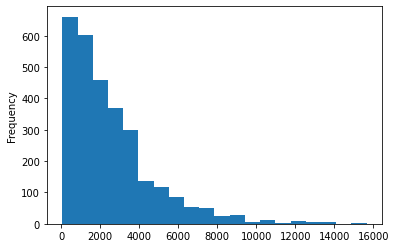

In [ ]:
sr_employ.plot.hist(bins=20)

### Log10 transformation

A base-10 logarithmic transformation removes the outliers. This is useful for a regression.

In [ ]:
sr_employ_log10 = np.log10(sr_employ)

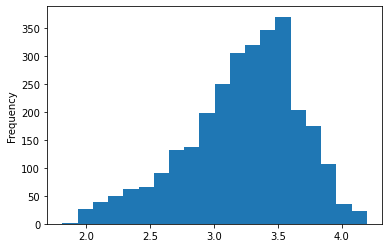

In [ ]:
sr_employ_log10.plot.hist(bins=20)

In [ ]:
df_data.loc[:,'DAYS_EMPLOYED_LOG10'] = sr_employ_log10

### Binning
Instead of knowing how many days exactly the employment duration was, what matters for a classifier is the rough range. That is, a categorization into whether a client just started, has some experience, is very experienced, etc. We achieve this through binning.

In [ ]:
sr_bins = pd.cut(sr_employ, 10)
sr_bins.value_counts()

(49.404, 1624.6]      1263
(1624.6, 3184.2]       829
(3184.2, 4743.8]       437
(4743.8, 6303.4]       202
(6303.4, 7863.0]       105
(7863.0, 9422.6]        55
(9422.6, 10982.2]       20
(12541.8, 14101.4]      12
(10982.2, 12541.8]      11
(14101.4, 15661.0]       1
Name: DAYS_EMPLOYED, dtype: int64

In [ ]:
df_data.loc[:,'DAYS_EMPLOYED_BINS'] = sr_bins.cat.codes

## Total income

A similar argument can be made for total income. We use log-10 transformation and binning.

In [ ]:
sr_income = df_data.loc[:,'AMT_INCOME_TOTAL']

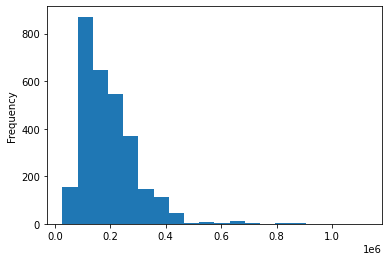

In [ ]:
sr_income.plot.hist(bins=20)

### Log10 transformation

In [ ]:
sr_income_log10 = np.log10(df_data.loc[:,'AMT_INCOME_TOTAL'])

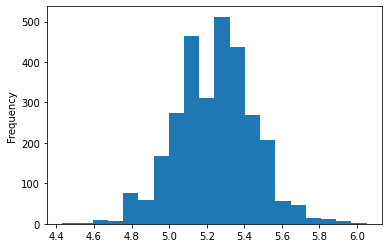

In [ ]:
sr_income_log10.plot.hist(bins=20)

In [ ]:
df_data.loc[:,'AMT_INCOME_TOTAL_LOG10'] = sr_income_log10

### Binning

In [ ]:
sr_bins = pd.cut(sr_income, 10)

In [ ]:
df_data.loc[:,'AMT_INCOME_TOTAL_BINS'] = sr_bins.cat.codes

# Linear Regression

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [ ]:
sr_endog = df_data.loc[:,'DEFAULTED'].astype(float)

df_exogs = df_data.loc[:,[
  'DAYS_EMPLOYED_LOG10',
  'AMT_INCOME_TOTAL_LOG10', 
  'FEMALE',
  'PENSIONER', 
  'CORE STAFF', 
  'LOWER SECONDARY', 
  'CIVIL MARRIAGE', 
  'MUNICIPAL APARTMENT', 
]]
df_exogs = sm.add_constant(df_exogs)
df_exogs.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,DAYS_EMPLOYED_LOG10,AMT_INCOME_TOTAL_LOG10,FEMALE,PENSIONER,CORE STAFF,LOWER SECONDARY,CIVIL MARRIAGE,MUNICIPAL APARTMENT
ID,,,,,,,,,
5088290,1.0,2.454845,5.352183,0,0,0,0,0,0
5135669,1.0,3.894316,5.334454,1,0,0,0,0,0
5143600,1.0,3.522835,4.954243,1,0,0,0,1,0
5038615,1.0,3.514813,5.051153,1,0,1,0,0,0
5050542,1.0,3.489677,5.352183,0,0,0,0,1,0


## Econometric view: with `statsmodels`

In [ ]:
linreg_sm = sm.OLS(
    endog=sr_endog,
    exog=df_exogs,
).fit()

print(linreg_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              DEFAULTED   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     16.11
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           1.69e-23
Time:                        15:52:08   Log-Likelihood:                -1027.4
No. Observations:                2935   AIC:                             2073.
Df Residuals:                    2926   BIC:                             2127.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

## Machine learning: with `scikit-learn`

In [ ]:
X = df_exogs.values
y = sr_endog.values

In [ ]:
linreg_ml = LinearRegression(fit_intercept=False)
linreg_ml.fit(X, y)

LinearRegression(fit_intercept=False)

In [ ]:
linreg_ml.coef_

array([ 0.3821456 , -0.07890382,  0.00530433, -0.03677142,  0.84535328,
        0.04088663,  0.1170635 , -0.01044891,  0.0264349 ])

In [ ]:
linreg_ml.score(X, y)

0.042188629479862794

# Classification

Until now we have used linear regressions to best predict the outcome. The results are very poor. With $R^2$ of 3-4%, there is little hope for this to continue well, especially if we are concerned about "external validity". 

This is not surprising since we do not have a regression problem. Instead, the outcome is binary. We are not that much interested in a trend or "regressing toward the mean". A better approach is classification.

In [ ]:
sr_endog = df_data.loc[:,'DEFAULTED'].astype(float)

df_exogs = df_data.loc[:,[
  'DAYS_EMPLOYED_LOG10',
  'AMT_INCOME_TOTAL_LOG10', 
  'DAYS_EMPLOYED_BINS',
  'AMT_INCOME_TOTAL_BINS', 
  'FEMALE',
  'PENSIONER', 
  'CORE STAFF', 
  'LOWER SECONDARY', 
  'CIVIL MARRIAGE', 
  'MUNICIPAL APARTMENT', 
]]
df_exogs = sm.add_constant(df_exogs)
df_exogs.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,DAYS_EMPLOYED_LOG10,AMT_INCOME_TOTAL_LOG10,DAYS_EMPLOYED_BINS,AMT_INCOME_TOTAL_BINS,FEMALE,PENSIONER,CORE STAFF,LOWER SECONDARY,CIVIL MARRIAGE,MUNICIPAL APARTMENT
ID,,,,,,,,,,,
5088290,1.0,2.454845,5.352183,0,1,0,0,0,0,0,0
5135669,1.0,3.894316,5.334454,4,1,1,0,0,0,0,0
5143600,1.0,3.522835,4.954243,2,0,1,0,0,0,1,0
5038615,1.0,3.514813,5.051153,2,0,1,0,1,0,0,0
5050542,1.0,3.489677,5.352183,1,1,0,0,0,0,1,0


# Preparation

At the beginning of each notebook, we have a short preparation section. This section will do three things. First of all it will loads all the necessary packages or download and install them. Secondly it will also download and extract the data we are going to use during the tutorial. The third thing is to run most of the code from the previous noteboo so we can continue working with the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!gdown 1-3c9BhPfl6D92HvTI4kNd0MfmTquiUwQ
!gdown 1-5ZzK3EAqc-i3AgnLOSZXTGGZsEPEmzH

In [ ]:
from sklearn.preprocessing import StandardScaler

## Logistic regression

<img src="http://dieter.wang/files/images/fig_linreg-logitreg.png" />

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
mdl_logit = LogisticRegression(
    fit_intercept=True
).fit(
    X=X,
    y=y,
)

In [ ]:
y_pred_logit = mdl_logit.predict(X)
y_pred_logit.sum()

13.0

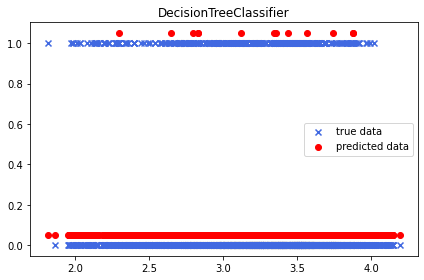

In [ ]:
x = df_exogs['DAYS_EMPLOYED_LOG10']
plt.scatter(x, y, marker='x', color='royalblue', label='true data')
plt.scatter(x, y_pred_logit+.05, marker='o', color='r', label='predicted data')
plt.title('LogisticRegression')
plt.legend()
plt.tight_layout()